### Advection diffusion 

In [17]:

import numpy as np
import scipy
import skfem    
#https://scikit-fem.readthedocs.io/en/latest/index.html

import matplotlib.pyplot as plt
#import importlib  # for reloading routines
%matplotlib inline


Solving the advection/diffusion equation using the Crank Nicolson scheme on a triangular mesh of the
circle.   The advection is counter clockwise rotation. The key to getting this to work is to use .T within the backsolve. 

For $u({\bf x}, t)$ the advection diffusion equation 
$$ \partial_t u +  ({\bf a} \cdot \nabla)  u  = D_u \Delta u$$
The weak form 
$$ \int_\Omega (\partial_t u) v\ dx  = - \int_\Omega v\ (( {\bf a} \cdot \nabla) u) \ dx 
- D_u \int_\Omega \nabla u \cdot \nabla v \ dx + D_u\int_{\partial \Omega} v \nabla u \cdot ds $$

We start with ${\bf a}$ giving solid body rotation with domain $\Omega$ the unit radius disk. 

For a disk with origin at the center, we let 
$${\bf a} = \omega (x \hat {\bf  y} - y \hat {\bf x}) $$
which is counter clockwise with angular rotation rate $\omega$. 

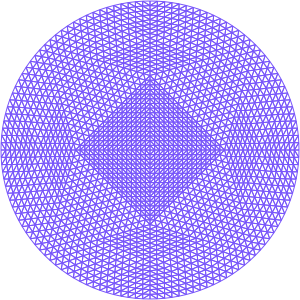

In [19]:

from scipy.sparse.linalg import splu  # for sparse matrices, 
# returns something like invA with LU decomp which can be applied with solve to solve Ax = b for x

from skfem.models.poisson import laplace, mass
from skfem.visuals.matplotlib import plot

mcirc= skfem.MeshTri.init_circle(5,smoothed=False)  # make a triangular mesh of the unit circle, number is refinement level
mcirc # show the mesh

In [21]:
# display single field, calls skfem's plot routine 
def disp(mesh,u,basis,t):
    fig,ax = plt.subplots(1,1,figsize=(3,3),sharex=True,sharey=True)
    ax.set_aspect('equal');
    ax_j0 = plot(mesh, u[basis.nodal_dofs.flatten()], shading='gouraud', ax = ax)
    field0 = ax.get_children()[0]  # vertex-based temperature-colour
    fig.colorbar(field0,shrink=0.7)
    title = ax.set_title(f'$t$ = {t:.3f}')


In [32]:
element = skfem.ElementTriP1()  #  a triangular element
basis = skfem.Basis(mcirc, element)
fbasis = skfem.FacetBasis(mcirc,element)  # facet basis in case we want a non-zero Neumann condition 

dt = .005   # timestep 
D_u = 1e-2  # diffusion coeff
om_circ = 1.0;    # angular rotation rate

@skfem.LinearForm   # same as unit_load
def rhs(v,_):
    return 1.0 * v   # useful for integrals on the boundary 

@skfem.BilinearForm   # for advection 
def advection(u, v, w):
    #x = w.x[0];  y = w.x[1];  r = np.sqrt(x**2 + y**2)
    from skfem.helpers import grad
    return v*(w.x[1]*grad(u)[0] - w.x[0]*grad(u)[1])  
    # equivalently return (w.x[1]*u.grad[0] - w.x[1]*u.grad[1])*v
    # this is (a dot nabla u)v - rotation with omega = 1  is (r x nabla u) v 
    # if rotation v = r x Omega  giving r x Omega dot nabla following from scalar tripple product
    # https://en.wikipedia.org/wiki/Triple_product#Scalar_triple_product

L_advec = skfem.asm(advection, basis) 
L_lap = skfem.asm(laplace, basis) 
M = skfem.asm(mass, basis)  # mass matrix (sizes of triangles) 

L = D_u * L_lap + om_circ * L_advec
theta = 0.5                     # Crank–Nicolson algorithm which is meant for diffusive equations not advection 
A = M + theta * L * dt
B = M - (1 - theta) * L * dt  
backsolve = splu(A.T).solve  # .T as splu prefers CSC which is a sparse matrix format (compressed sparse column)

u_nb = -0e-5  # normal components of slopes for Neumann BC regions 
Bint = skfem.asm(rhs,fbasis) * dt * D_u * u_nb

# do a single timestep, return u field and time 
# requires globals:  dt, backsolve, B
def one_step(t,u):
    t += dt 
    new_u = backsolve(B.T @ u + Bint)  # the advection does not work unless .T is on B -- It took me a while to figure this out!
    # the use of .T here conflicts with example ex19.py
    return t,new_u


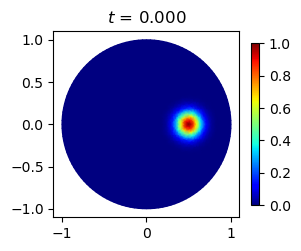

In [28]:
# initial conditions 
x_p = basis.doflocs[0]; y_p = basis.doflocs[1];  t = 0 
x_0 =0.5; y_0= 0.0; sig = 0.1
r2 = (x_p - x_0)**2 + (y_p - y_0)**2 ;
u_init = np.exp(-0.5*r2/sig**2)   # make u have an offset gaussian peak 
disp(mcirc,u_init,basis,t)

#print(np.exp(-0.5)/sig) # is consistent with figure below  #u0 = basis.zeros()  

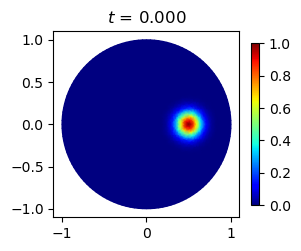

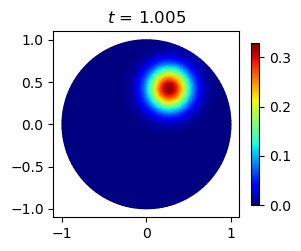

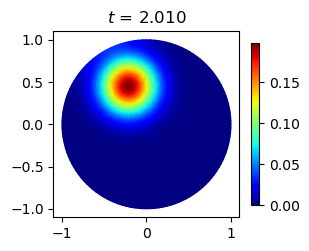

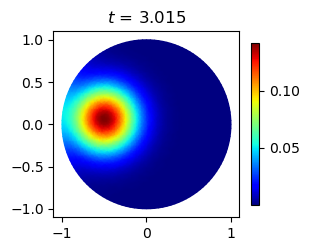

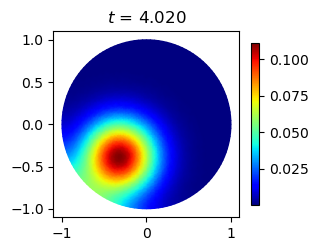

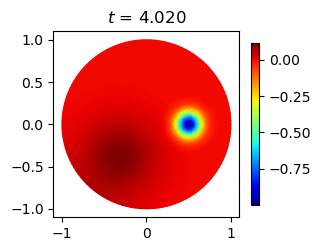

In [34]:
u = u_init;  t=0; nj = int(1/dt)+1
disp(mcirc,u,basis,t)
for j in range(4):
    for i in range(nj):
        t, u= one_step(t,u)  
    disp(mcirc,u,basis,t)
disp(mcirc,u-u_init,basis,t)  

In [39]:
#looks ok